In [1]:
import numpy as np
import cv2
#import pandas as pd
import logging

#from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np
import random
import math
from math import sin, cos, radians
from shapely.geometry import Polygon,Point, MultiPoint, MultiPolygon
from shapely import affinity
from shapely.ops import unary_union
from IPython.display import clear_output


%matplotlib inline
random.seed = 50

In [2]:
LOG_FILENAME = "logfile.log"
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(filename=LOG_FILENAME,level=logging.DEBUG)    
logging.info('Job Started...')

In [3]:
## locations with size from 1 to 10

sizes  =       [100,200,250,300,350,400,500,1000,2000,4000]
shapes =       [[10,10],[10,20],[10,25]  ,[15,20], [15,23], [20,20] ,[20,25] ,[25,40] ,[50,40]  ,[50,80]  ]
vernac =       [74,88,35,16,9,6,0,0,0,0] # urban/rural
worklocs =     [71,38,14, 9,6,1,0,0,0,0] # urban/industrial/rural
publicplaces = [0,0,0,0,6,5,4,3,2,1] ## (None,Garden,Square) (N,N,N,N,S,SG,SG,SG,G,G)
gardens =      [0,0,0,0,0,3,2,2,2,1]
plaza   =      [0,0,0,0,6,2,2,1,0,0]

In [4]:
lists_of_lists = [vernac, worklocs, publicplaces, gardens, plaza]
sz = [sum(x) for x in zip(*lists_of_lists)]
size_prob = [x/sum(sz) for x in sz]


### Start all 0

In [5]:
vec_bld = []
avail_p = []
roads   = []

In [6]:
def rotate_tran(p1,rot,loc):
    p2 = affinity.rotate(p1,rot,(0,0))
    p3 = affinity.translate(p2,xoff=loc[0],yoff=loc[1])
    return p3

In [7]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

In [8]:
def show_bld():
    print("Buildings")
    for bldings in vec_bld:
        print(bldings)
        
    print("\nPoints")
    for av in avail_p:
        [p1,edge,direc,prob,corner] = av
        print(p1,edge,direc,prob,corner)
        
def draw_bld(Roads = True, points = True, Buildings = True, text = ""):
    global vec_mask
    
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='black', edgecolor='black')
    plt.axis('equal')
    plt.text(10,10, text, fontsize=10)

    for a in vec_mask:
        plt.plot(*a.exterior.xy)
        for s in a.interiors:
            x,y = s.xy
            plt.plot(x,y)
        
    if points:
        for av in avail_p:
            [p1,edge,direc,prob,corner] = av
            plt.scatter(p1.x,p1.y)
        
    plt.show()


In [9]:
thisroads = None

def clean_points():
    global thisroads
                
    
    to_remove = []
    for bldings in vec_bld:
        for possible_locs in avail_p:
            [p1,edge,direc,prob,corner] = possible_locs
            if bldings.contains(p1) or bldings.touches(p1) or bldings.exterior.distance(p1)<3:
                to_remove.append(possible_locs)
    
    
    for thisroads in roads:
        for possible_locs in avail_p:
            [p1,edge,direc,prob,corner] = possible_locs
            if thisroads.contains(p1) or thisroads.touches(p1):
                to_remove.append(possible_locs)

    for ind in to_remove:
        if ind in avail_p:
            avail_p.remove(ind)
    # except:
    #      logging.debug("ERROR")
                    

    

### Place Building
- Building shape - polygon
- edge - locate which vertex at location
- bld_rot - Rotation
- location - vertex to location

In [10]:
ROAD_SIZE = 20
ANGLE_DEV_STD_DEV = 1
PREFERENCE_STRAIGHT = 2
### Assumption of 4 point polygons
### BLD is a shape of polygon 
### Vertex is the vertex number to be located in coord location
### bld_rot if the angle of rotation to place the building
### location co-ord where to put building
### corner is 

BBCON = 0
BRCON = 0
RBCON = 0

vec_mask = Polygon()

def place_bld(bld, vertex, bld_rot, location,corner):
    global roads, BBCON, BRCON, RBCON, vec_mask
    
    [bx,by] = bld
    bld_rot = bld_rot + np.random.normal(0,ANGLE_DEV_STD_DEV)
    
    ## Choose vertex point
    if vertex==0:
        pp = Polygon([(0,0),(bx,0),(bx,by),(0,by)])
        rd = Polygon([(-5,-0.5),(bx+5,-0.5),(bx+5,0.5-ROAD_SIZE),(-5,0.5-ROAD_SIZE)])
        rdl = Polygon([(0.5-ROAD_SIZE,by),(-0.5,by),(-0.5,0.5-ROAD_SIZE),(0.5-ROAD_SIZE,0.5-ROAD_SIZE)])
        rdr = Polygon([(bx+0.5,by),(bx+ROAD_SIZE-0.5,by),(bx+ROAD_SIZE-0.5,0.5-ROAD_SIZE),(bx+0.5,0.5-ROAD_SIZE)])
        
    elif vertex==1:
        pp = Polygon([(-bx,0),   (0,0),   (0,by),          (-bx,by)])
        rd = Polygon([(-5-bx,-0.5),(5,-0.5),(5,0.5-ROAD_SIZE),(-5-bx,0.5-ROAD_SIZE)])
        rdl = Polygon([(-bx-0.5,by),(-bx-ROAD_SIZE+0.5,by),(-bx-ROAD_SIZE+0.5,0.5-ROAD_SIZE),(-bx-0.5,0.5-ROAD_SIZE)])
        rdr = Polygon([(0.5,by),(ROAD_SIZE-0.5,by),(ROAD_SIZE-0.5,0.5-ROAD_SIZE),(0.5,0.5-ROAD_SIZE)])
        
    elif vertex==2:
        pp = Polygon([(-bx,-by),(0,-by),(0,0),(-bx,0)])
        rd = Polygon([(-5-bx,-by-0.5),(5,-by-0.5),(5,-by+0.5-ROAD_SIZE),(-5-bx, -by+0.5-ROAD_SIZE)])
        rdl = Polygon([(-bx-0.5,0),(-bx+0.5-ROAD_SIZE,0),(-bx+0.5-ROAD_SIZE,-by+0.5-ROAD_SIZE),(-bx-0.5,-by+0.5-ROAD_SIZE)])
        rdr = Polygon([(0.5,0),(ROAD_SIZE-0.5,0),(ROAD_SIZE-0.5,-by+0.5-ROAD_SIZE),(0.5,-by+0.5-ROAD_SIZE)])
                      
    elif vertex==3:
        pp = Polygon([(0,-by),    (bx,-by),    (bx,0),                (0,0)])
        rd = Polygon([(-5,-by-0.5),(bx+5,-by-0.5),(bx+5,-by+0.5-ROAD_SIZE),(-5, -by+0.5-ROAD_SIZE)])
        rdl = Polygon([(-0.5,0),(-ROAD_SIZE+0.5,0),(-ROAD_SIZE+0.5,-ROAD_SIZE-by+0.5),(-0.5,-ROAD_SIZE-by+0.5)])
        rdr = Polygon([(bx+0.5,0),(bx-0.5+ROAD_SIZE,0),(bx-0.5+ROAD_SIZE,-ROAD_SIZE-by+0.5),(bx+0.5,-ROAD_SIZE-by+0.5)])
        
    ## Rotate and Move building and place it in list
    this_building = rotate_tran(pp,bld_rot,location)
    
    ## Check new building does not intersect other buildings
    freespace = True   
    if vec_mask.intersects(this_building):
            freespace = False
            BBCON = BBCON + 1
    
    ### Check that new roads do not overlap existing building
    if freespace:
        checkrd=[]
        checkrd.append(rotate_tran(rd,bld_rot,location))
        if corner == 1: checkrd.append(rotate_tran(rdr,bld_rot,location))
        if corner == 2: checkrd.append(rotate_tran(rdl,bld_rot,location))
        for road in checkrd:
            for bldings in vec_bld:
                if bldings.intersects(road):
                    RBCON = RBCON + 1
                    freespace = False
                    break

    if freespace: 
        # BUILDINGS
        ## Put building in place
        vec_bld.append(this_building)
        vec_mask = unary_union([vec_mask, vec_bld[-1]])
    
        ## Create Points of possible buildings
        x,y = pp.exterior.coords.xy
        xx=x[0]
        yy=y[0]
        
        ##PROPOSALS
        ## If chosen a proposal inside corner don't propose building in the middle of road
        if corner!= 2: 
            for loop in range(PREFERENCE_STRAIGHT): avail_p.append([rotate_tran(Point(xx-5   ,yy),bld_rot,location),1,bld_rot    ,5,  0]) 
            avail_p.append([rotate_tran(Point(xx-5   ,yy),bld_rot,location),2,bld_rot-90 ,1,  1])
            
        if corner!= 1: 
            for loop in range(PREFERENCE_STRAIGHT): avail_p.append([rotate_tran(Point(xx+bx+5,yy),bld_rot,location),0,bld_rot      ,5,  0]) #right
            avail_p.append([rotate_tran(Point(xx+bx+5,yy),bld_rot,location),3,bld_rot+90   ,1 , 2])
        
        avail_p.append([rotate_tran(Point(xx     ,yy-ROAD_SIZE)     ,bld_rot,location),1,bld_rot+180,5,0])
            
        ##ROADS
        roads.append(rotate_tran(rd,bld_rot,location))
        vec_mask = unary_union([vec_mask, roads[-1]])
        
        ## Insert blank crossroads
        if corner == 1: 
            roads.append(rotate_tran(rdr,bld_rot,location))
            vec_mask = unary_union([vec_mask, roads[-1]])
            
        if corner == 2: 
            roads.append(rotate_tran(rdl,bld_rot,location))        
            vec_mask = unary_union([vec_mask, roads[-1]])
        
        ## Clean any proposals that lie within buildings
        clean_points()
    else:
        logging.debug("B2B:"+str(BBCON)+"-B2R:"+str(BRCON)+"-R2B:"+str(RBCON))
       
    return freespace

In [11]:
vec_bld = []
avail_p = []
#roads   =  MultiPolygon([])
#random_choice = np.random.choice(np.arange(1, 11), p=size_prob)
place_bld( shapes[0], 3, 0, (0,0) ,0) #random.randint(0,11)*30, (250,250))

True

In [12]:
NO_OF_BUILDINGS = 2
fitted = 0 
not_fitted = 0
draw_per = 0 
for t in range(NO_OF_BUILDINGS):
    
    ### Find random available spot
    random.shuffle(avail_p)
    [p1,edge,direc,prob,corner] = avail_p.pop()
    
    foundplace = False
    cnt=0
    
    shapes_now = shapes.copy()
    size_p_now = size_prob.copy()
    
    while foundplace == False and len(shapes_now)>0:
        cnt = cnt + 1
        ## Choose random building size
        shape_choice = random.choices(shapes_now ,weights = size_p_now, k=1)
        
        shindex = shapes_now.index(shape_choice[0])
        del shapes_now[shindex]
        del size_p_now[shindex]
        
        if len(shapes_now)>0:
        
            b=[a/sum(size_p_now) for a in size_p_now]
            b[0]=b[0]+(1-sum(b))
            size_p_now=b.copy()

            ## Try to place building in spot
            foundplace = place_bld(shape_choice[0], edge, direc, [p1.x,p1.y], corner)
        
    
    ### Every 50 tries Draw MAP
    draw_per = draw_per + 1
    if draw_per>50:
        clear_output(wait=True)
        draw_bld(Roads = True, Buildings= True, points = True,text = str(len(vec_bld))+"_"+str(t))
        draw_per = 0
        
    print("\rAvailable Space:",len(avail_p), " Buildings:",len(vec_bld),":",t,end="",flush=True)
    


Available Space: 9  Buildings: 3 : 1

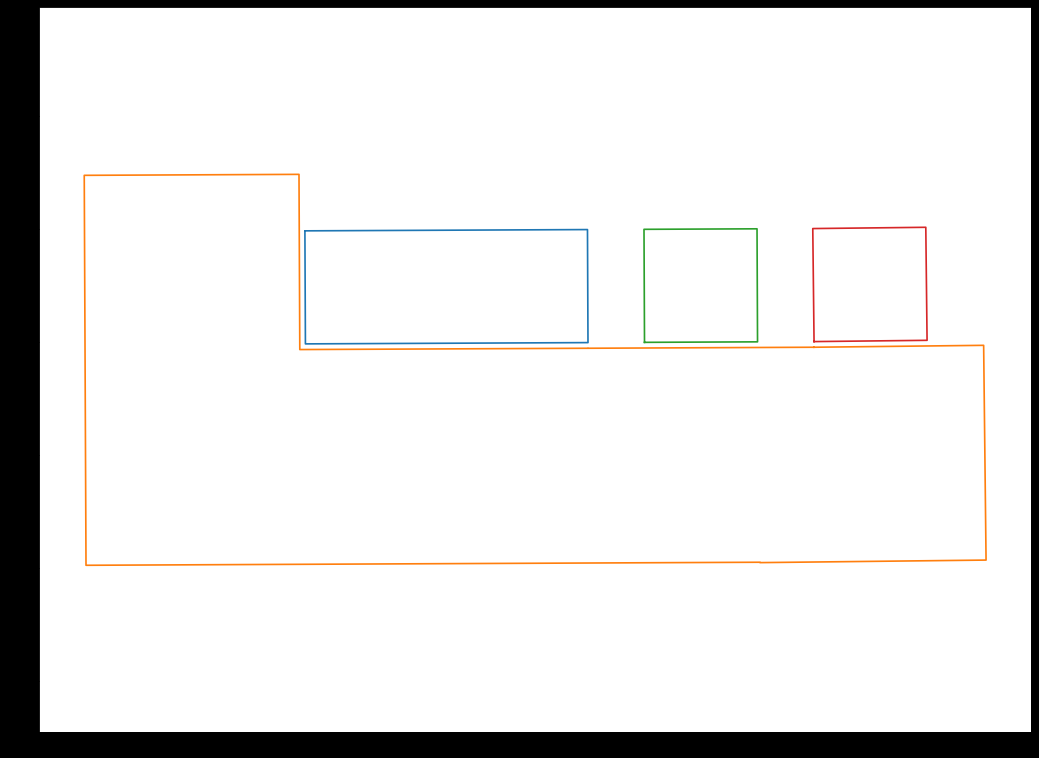

In [13]:
 draw_bld(Roads = True, Buildings= True, points = False)

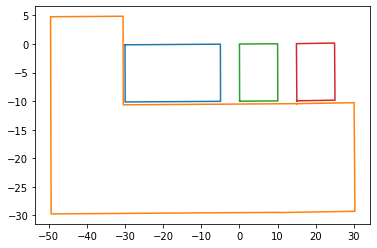

In [14]:
_w = vec_mask
for a in _w:
    plt.plot(*a.exterior.xy)
    for s in a.interiors:
        x,y = s.xy
        plt.plot(x,y)

if _w.type == 'Polygon':
    plt.plot(*_w.exterior.xy)
    for a in _w.interiors:
        x,y = a.xy
        plt.plot(x,y);

else:
    x,y = _w.boundary.xy
    plt.plot(x,y,color='black')